# 1. Import libraries

In [1]:
import numpy as np
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from datetime import timedelta
from tqdm import tqdm
from tqdm.notebook import trange

try:
    import holidays
except:
    !pip install holidays
    import holidays
try:
    import xgboost as xgb
except:
    !pip install xgboost
    import xgboost as xgb
try:
    from lunardate import LunarDate
except:
    !pip install lunardate
    from lunardate import LunarDate

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.fft import fft
import warnings

warnings.simplefilter(action='ignore')

# 2. Load data

In [2]:
# Define url path to CSV
annex1 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex1.csv'
annex2 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex2.csv'
annex3 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex3.csv'
annex4 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex4.csv'

In [3]:
def get_df_from_url(url):
    # Create request response
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Create a file-like object from the raw content
        csv_content = StringIO(response.text)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_content)

        # Return DataFrame
        return df
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")

df_item = get_df_from_url(annex1)
df_transaction = get_df_from_url(annex2)
df_wholesale = get_df_from_url(annex3)
df_loss = get_df_from_url(annex4)

# 3. Merge and aggregate data

In [4]:
def merge_all_df(df_transaction: pd.DataFrame = df_transaction,
                 df_item: pd.DataFrame = df_item,
                 df_wholesale: pd.DataFrame = df_wholesale,
                 df_loss: pd.DataFrame = df_loss):

    df_merge = df_transaction.merge(df_item,
                                    how = 'left',
                                    on = 'Item Code')
    df_merge = df_merge.merge(df_wholesale,
                            how = 'left',
                            on = ['Date', 'Item Code'])
    df_merge = df_merge.merge(df_loss.drop('Item Name', axis = 1),
                            how = 'left',
                            on = 'Item Code')
    
    return df_merge

df_merge = merge_all_df()

In [5]:
# Create Sales column
df_merge['Sales'] = df_merge['Unit Selling Price (RMB/kg)'] * df_merge['Quantity Sold (kilo)']

# Aggregate as new table
df_agg = df_merge.groupby(['Date', 'Category Code'], as_index = False)['Sales'].sum()
df_agg.head()

,Date,Category Code,Sales
0,2020-07-01,1011010101,1503.7896
1,2020-07-01,1011010201,592.5300
2,2020-07-01,1011010402,70.2838
3,2020-07-01,1011010501,176.8180
4,2020-07-01,1011010504,759.9902


# 4. Feature Engineering

In [18]:
def create_date_feature(df: pd.DataFrame,
                       date_column: str):
    # Convert the 'Date' column to datetime type
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].astype('datetime64[ns]')

    # Extract date components
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday is 0 and Sunday is 6
    df['WeekNumber'] = df['Date'].dt.isocalendar().week
    df['WeekNumber'] = df['WeekNumber'].astype('int64')
    df['Quarter'] = df['Date'].dt.quarter
    
    return df

def is_holiday(date_value):
    china_holidays = holidays.country_holidays('CN')
    value = 1 if date_value in china_holidays else 0
    return value

def create_lag_feature(df: pd.DataFrame,
                       days: int):
    
    df[f'lag_{days}'] = df['Sales'].shift(days)
    df[f'lag_{days}'] = df[f'lag_{days}'].astype('float64')
    
    return df

def get_chinese_new_year_dates(start_year, end_year):
    chinese_new_year_dates = []

    for year in range(start_year, end_year + 1):
        lunar_date = LunarDate(year, 1, 1)
        cny_date = pd.Timestamp(lunar_date.toSolarDate())

        chinese_new_year_dates.append({'Chinese New Year Date': cny_date})

    chinese_new_year_df = pd.DataFrame(chinese_new_year_dates)
    chinese_new_year_df['Last Chinese New Year Date'] = chinese_new_year_df['Chinese New Year Date'].shift(1)
    chinese_new_year_df.dropna(subset=['Last Chinese New Year Date'], inplace = True)
    
    return chinese_new_year_df

def get_chinese_new_year_period(df, days):
    days = 7
    # new_years = df['Chinese New Year Date'].unique()
    # for new_year in new_years:
    new_year_dict = dict(zip(df['Chinese New Year Date'], df['Last Chinese New Year Date']))
    for this_year, last_year in new_year_dict.items():
        for day in range(-days, days + 1):
            if day != 0:
                df = pd.concat([df, pd.DataFrame({'Chinese New Year Date': [this_year + timedelta(days = day)],
                                                  'Last Chinese New Year Date': [last_year + timedelta(days = day)]})],
                               axis = 0,
                               ignore_index = True)
    return df

def create_last_new_year_feature(df: pd.DataFrame,
                                 days_before_after: int):
    
    # Get start and end year to generate Chinese New Year DataFrame from input data
    df['Date'] = df['Date'].astype('datetime64[ns]')
    df['Date'] = pd.to_datetime(df['Date'])
    start_year = df['Date'].min().year
    end_year = df['Date'].max().year
    
    # Get Chinese New Year DataFrame
    df_chinese_new_year = get_chinese_new_year_dates(start_year = start_year,
                                                     end_year = end_year)
    df_chinese_new_year_period = get_chinese_new_year_period(df = df_chinese_new_year,
                                                             days = 7)

    # Cast date column
    df['Date'] = pd.to_datetime(df['Date'])

    # Merge current new year date with last new year date
    df_last_new_year = df.copy()
    df_last_new_year = df_last_new_year.merge(df_chinese_new_year_period,
                                              how = 'left',
                                              left_on = 'Date',
                                              right_on = 'Last Chinese New Year Date')
    # Cleanup DataFrame
    df_last_new_year = df_last_new_year[~df_last_new_year['Last Chinese New Year Date'].isna()][['Chinese New Year Date', 'Category Code', 'Sales']]

    # Change column name before merge avoiding duplicated columns
    df_last_new_year.columns = ['Date', 'Category Code', 'Last New Year Sales']

    # Merge current new year with current new year to get "Last New Year Sales"
    df = df.merge(df_last_new_year,
                  on = ['Date', 'Category Code'],
                  how = 'left')

    return df

In [19]:
def category_feature_engineering(df_category: pd.DataFrame):
    df_category = create_date_feature(df_category,
                                    date_column = 'Date')
    df_category = create_lag_feature(df = df_category,
                                    days = 364)
    df_category = create_lag_feature(df = df_category,
                                    days = 7)
    df_category = create_lag_feature(df = df_category,
                                    days = 14)
    df_category = create_lag_feature(df = df_category,
                                    days = 28)
    df_category = create_last_new_year_feature(df = df_category,
                                            days_before_after = 7)
    df_category['is_holiday'] = df_category['Date'].apply(is_holiday)

    df_final = df_category.drop(['Date', 'Category Code'], axis = 1)
    df_final['Sales'] = df_final['Sales'].astype('float64')
    df_final['Last New Year Sales'] = df_final['Last New Year Sales'].astype('float64')

    return df_final

def category_date_feature(df_category: pd.DataFrame):
    df_category = create_date_feature(df_category,
                                    date_column = 'Date')
    df_category['is_holiday'] = df_category['Date'].apply(is_holiday)

    return df_category

def category_lag_feature(df_category: pd.DataFrame):
    df_category = create_lag_feature(df = df_category,
                                    days = 364)
    df_category = create_lag_feature(df = df_category,
                                    days = 7)
    df_category = create_lag_feature(df = df_category,
                                    days = 14)
    df_category = create_lag_feature(df = df_category,
                                    days = 28)
    df_category = create_last_new_year_feature(df = df_category,
                                            days_before_after = 7)

    df_final = df_category.drop(['Date', 'Category Code'], axis = 1)

    return df_final

# 5. Train and evaluate

## 5.1 Loop Category and Cross Validition

In [8]:
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define parameter lists
n_estimators_list = [1000, 5000, 10000]
learning_rate_list = [0.01, 0.005, 0.001, 0.0005]
max_depth_list = [3, 5]
subsample_list = [0.5, 0.75]
colsample_bytree_list = [0.5, 1.0]
early_stopping_rounds_list = [100, 200, 400]

# Calculate the total number of combinations
total_combinations = (
    len(n_estimators_list) *
    len(learning_rate_list) *
    len(max_depth_list) *
    len(subsample_list) *
    len(colsample_bytree_list) *
    len(early_stopping_rounds_list)
)

scaler = StandardScaler()
# categories = [1011010101]
categories = df_agg['Category Code'].unique()
category_best_params = {}
category_best_score = {'Category': [],
                       'RMSE': [],
                       'Normalized RMSE': [],
                       'MAPE': []}
for category in categories:
    print('\n######################################################')
    print(f'################ CATEGORY: {category} ################')
    print('######################################################\n')

    df_category = df_agg[df_agg['Category Code'] == category]

    # Feature Engineering
    df_final = category_feature_engineering(df_category = df_category)

    # Create a progress bar for the overall progress
    overall_progress_bar = tqdm(total = total_combinations,
                                desc = 'Overall Progress',
                                unit = 'combination')
    
    # Loop all parameters
    best_params = {}
    best_score = None
    for n_estimators in n_estimators_list:
        for learning_rate in learning_rate_list:
            for max_depth in max_depth_list:
                for subsample in subsample_list:
                    for colsample_bytree in colsample_bytree_list:
                        for early_stopping_rounds in early_stopping_rounds_list:
                             
                            # Set up XGBRegressor
                            xgb_r = xgb.XGBRegressor(
                                n_estimators = n_estimators,
                                eval_metrics = mean_squared_error,
                                learning_rate = learning_rate,
                                max_depth = max_depth,
                                subsample = subsample,
                                colsample_bytree = colsample_bytree,
                                early_stopping_rounds = early_stopping_rounds,
                                random_state = 244
                            )

                            # Define X, y
                            X = df_final.drop('Sales', axis = 1)
                            y = df_final[['Sales']]

                            rmse_list = []
                            normalized_rmse_list = []
                            mape_list = []
                            # Cross Validate
                            for train_index, test_index in tscv.split(X):
                                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                                # Scale X
                                X_train[X_train.columns] = scaler.fit_transform(X_train)
                                X_test[X_test.columns] = scaler.transform(X_test)

                                # Fit the model
                                xgb_r.fit(
                                    X = X_train,
                                    y = y_train,
                                    eval_set = [(X_train, y_train), (X_test, y_test)],
                                    verbose = False
                                )

                                # Predict
                                y_pred = xgb_r.predict(X_test)

                                # Calculate score
                                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                                normalized_rmse = rmse / (float(y_test.max()) - float(y_test.min()))
                                mape = mean_absolute_percentage_error(y_true = y_test, y_pred = y_pred)

                                # Store RMSE for each fold
                                rmse_list.append(rmse)
                                normalized_rmse_list.append(normalized_rmse)
                                mape_list.append(mape)

                            
                            new_rmse = sum(rmse_list) / len(rmse_list)
                            new_normalized_rmse = sum(normalized_rmse_list) / len(normalized_rmse_list)
                            new_mape = sum(mape_list) / len(mape_list)
                            # print(f'n_estimators: {n_estimators} | learning_rate: {learning_rate} | max_depth: {max_depth} | subsample: {subsample} | colsample_bytree: {colsample_bytree} | early_stopping_rounds: {early_stopping_rounds} >>> RMSE: {new_rmse:.2f} | Normalized RMSE: {new_normalized_rmse:.2f} | MAPE: {new_mape:.2f} %')
                            if best_score is None:
                                best_score = new_rmse
                                best_normalized_rmse = new_normalized_rmse
                                best_mape = new_mape

                                # Update best_params
                                best_params['n_estimators'] = n_estimators
                                best_params['learning_rate'] = learning_rate
                                best_params['max_depth'] = max_depth
                                best_params['subsample'] = subsample
                                best_params['colsample_bytree'] = colsample_bytree
                                best_params['early_stopping_rounds'] = early_stopping_rounds
                            elif new_rmse < best_score:
                                best_score = new_rmse
                                best_normalized_rmse = new_normalized_rmse
                                best_mape = new_mape

                                # Update best_params
                                best_params['n_estimators'] = n_estimators
                                best_params['learning_rate'] = learning_rate
                                best_params['max_depth'] = max_depth
                                best_params['subsample'] = subsample
                                best_params['colsample_bytree'] = colsample_bytree
                                best_params['early_stopping_rounds'] = early_stopping_rounds
                            
                            # Update the overall progress bar
                            overall_progress_bar.update(1)

    # Close the overall progress bar
    overall_progress_bar.close()

    # Print the best parameters and corresponding mean squared error
    print(f'\nCategory {category} Best Parameters: {best_params}')
    print(f'Category {category} Best Score: {best_score}')

    # Store best_params for each category
    category_best_params[category] = best_params
    category_best_score['Category'].append(category)
    category_best_score['RMSE'].append(best_score)
    category_best_score['Normalized RMSE'].append(best_normalized_rmse)
    category_best_score['MAPE'].append(best_mape)

# Summarize
print('\n>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> SUMMARY <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<')
display(pd.DataFrame(category_best_params))
display(pd.DataFrame(category_best_score))


######################################################
################ CATEGORY: 1011010101 ################
######################################################



Overall Progress: 100%|██████████| 288/288 [39:20<00:00,  8.20s/combination]



Category 1011010101 Best Parameters: {'n_estimators': 5000, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.75, 'colsample_bytree': 0.5, 'early_stopping_rounds': 200}
Category 1011010101 Best Score: 309.0581559119968

######################################################
################ CATEGORY: 1011010201 ################
######################################################



Overall Progress: 100%|██████████| 288/288 [34:17<00:00,  7.15s/combination]



Category 1011010201 Best Parameters: {'n_estimators': 10000, 'learning_rate': 0.001, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.5, 'early_stopping_rounds': 400}
Category 1011010201 Best Score: 156.40109678989998

######################################################
################ CATEGORY: 1011010402 ################
######################################################



Overall Progress: 100%|██████████| 288/288 [21:55<00:00,  4.57s/combination]



Category 1011010402 Best Parameters: {'n_estimators': 5000, 'learning_rate': 0.001, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.5, 'early_stopping_rounds': 100}
Category 1011010402 Best Score: 216.2977724413237

######################################################
################ CATEGORY: 1011010501 ################
######################################################



Overall Progress: 100%|██████████| 288/288 [19:55<00:00,  4.15s/combination]



Category 1011010501 Best Parameters: {'n_estimators': 5000, 'learning_rate': 0.001, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.5, 'early_stopping_rounds': 200}
Category 1011010501 Best Score: 100.29919163584293

######################################################
################ CATEGORY: 1011010504 ################
######################################################



Overall Progress: 100%|██████████| 288/288 [22:06<00:00,  4.61s/combination]



Category 1011010504 Best Parameters: {'n_estimators': 1000, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.75, 'colsample_bytree': 1.0, 'early_stopping_rounds': 100}
Category 1011010504 Best Score: 408.6057863668257

######################################################
################ CATEGORY: 1011010801 ################
######################################################



Overall Progress: 100%|██████████| 288/288 [23:41<00:00,  4.94s/combination]


Category 1011010801 Best Parameters: {'n_estimators': 10000, 'learning_rate': 0.001, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.5, 'early_stopping_rounds': 100}
Category 1011010801 Best Score: 265.78633975804

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> SUMMARY <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


,1011010101,1011010201,1011010402,1011010501,1011010504,1011010801
n_estimators,5000.00,10000.000,5000.000,5000.000,1000.00,10000.000
learning_rate,0.01,0.001,0.001,0.001,0.01,0.001
max_depth,3.00,3.000,3.000,3.000,3.00,3.000
subsample,0.75,0.500,0.500,0.500,0.75,0.500
colsample_bytree,0.50,0.500,0.500,0.500,1.00,0.500
early_stopping_rounds,200.00,400.000,100.000,200.000,100.00,100.000


,Category,RMSE,Normalized RMSE,MAPE
0,1011010101,309.058156,0.112941,0.270468
1,1011010201,156.401097,0.136814,0.620382
2,1011010402,216.297772,0.123281,0.685395
3,1011010501,100.299192,0.113782,0.654450
4,1011010504,408.605786,0.102521,0.399783
5,1011010801,265.786340,0.121651,0.430013


In [20]:
category_best_params = {1011010101: {'n_estimators': 5000,
  'learning_rate': 0.01,
  'max_depth': 3,
  'subsample': 0.75,
  'colsample_bytree': 0.5,
  'early_stopping_rounds': 200},
 1011010201: {'n_estimators': 10000,
  'learning_rate': 0.001,
  'max_depth': 3,
  'subsample': 0.5,
  'colsample_bytree': 0.5,
  'early_stopping_rounds': 400},
 1011010402: {'n_estimators': 5000,
  'learning_rate': 0.001,
  'max_depth': 3,
  'subsample': 0.5,
  'colsample_bytree': 0.5,
  'early_stopping_rounds': 100},
 1011010501: {'n_estimators': 5000,
  'learning_rate': 0.001,
  'max_depth': 3,
  'subsample': 0.5,
  'colsample_bytree': 0.5,
  'early_stopping_rounds': 200},
 1011010504: {'n_estimators': 1000,
  'learning_rate': 0.01,
  'max_depth': 3,
  'subsample': 0.75,
  'colsample_bytree': 1.0,
  'early_stopping_rounds': 100},
 1011010801: {'n_estimators': 10000,
  'learning_rate': 0.001,
  'max_depth': 3,
  'subsample': 0.5,
  'colsample_bytree': 0.5,
  'early_stopping_rounds': 100}}

## 5.2 Predict Future Period

In [83]:
def create_future_date_dataframe(df: pd.DataFrame,
                                 date_column: str,
                                 days: int = 60):
    try:
        start = dt.strptime(df[date_column].max(), '%Y-%m-%d').date() + timedelta(days = 1)
    except:
        start = df[date_column].max().date() + timedelta(days = 1)
    end = start + timedelta(days = days - 1)
    date_generated = [start + timedelta(days = x) for x in range(0, (end - start).days + 1)]
    df_date_future = pd.DataFrame(date_generated, columns = [date_column])
    return df_date_future

days_to_predict = 90

In [94]:
df_all = pd.DataFrame()
for category in categories:

    # Break DataFrame to Category
    df_category = df_agg[df_agg['Category Code'] == category]
    df_category.reset_index(inplace = True, drop = True)
    df_date_future = create_future_date_dataframe(df = df_category,
                                                date_column = 'Date',
                                                days = days_to_predict)

    # Feature Engineering
    df_train = df_category.copy()
    df_train = category_feature_engineering(df_category = df_train)

    # Split train and evaluate dataset
    train_idx_split = int(df_category.shape[0]*0.8)
    eval_idx_split = (df_category.shape[0])
    train = df_train.iloc[0:train_idx_split,:]
    eval = df_train.iloc[train_idx_split:eval_idx_split,:]

    # Create X and y
    X_train = train.drop('Sales', axis = 1)
    y_train = train[['Sales']]
    X_test = eval.drop('Sales', axis = 1)
    y_test = eval[['Sales']]

    # Feature Scaling
    X_train[X_train.columns] = scaler.fit_transform(X_train)
    X_test[X_test.columns] = scaler.transform(X_test)

    # Train
    xgb_r = xgb.XGBRegressor(**category_best_params[category], random_state = 244)
    xgb_r.fit(X_train,
            y_train,
            eval_set = [(X_train, y_train), (X_test, y_test)],
            verbose = False)

    # Loop through each date
    df_future = df_date_future.copy()
    df_future['Category Code'] = category
    df_future['Sales'] = None
    df_new_category = df_category.copy()
    for i in range(df_future.shape[0]):
        df_new_category = pd.concat([df_category, df_future.iloc[0:i+1,:]], axis = 0)
        df_new_category = category_feature_engineering(df_category = df_new_category)

        # Predict future date
        X_future = df_new_category.iloc[-1:].drop('Sales', axis =1)
        X_future[X_future.columns] = scaler.transform(X_future)
        y_pred = xgb_r.predict(X_future)

        # Update y_pred to the last row of Sales column (new date)
        df_future.iloc[i:i+1, df_future.columns.get_loc('Sales')] = y_pred[0]

    # Update df_new_category last loop
    df_new_category.iloc[-1, df_new_category.columns.get_loc('Sales')] = y_pred[0]
    
    # Merge to All Category DataFrame
    df_new_category['Category Code'] = category
    df_all = pd.concat([df_all, df_new_category],
                       axis = 0,
                       ignore_index = True)


In [95]:
def predict_future_sales(df: pd.DataFrame,
                         category_list: list,
                         category_params,
                         days_to_predict: int = 60):
    df_all = pd.DataFrame()
    for category in category_list:

        # Break DataFrame to Category
        df_category = df[df['Category Code'] == category]
        df_category.reset_index(inplace = True, drop = True)
        df_date_future = create_future_date_dataframe(df = df_category,
                                                    date_column = 'Date',
                                                    days = days_to_predict)

        # Feature Engineering
        df_train = df_category.copy()
        df_train = category_feature_engineering(df_category = df_train)

        # Split train and evaluate dataset
        train_idx_split = int(df_category.shape[0]*0.8)
        eval_idx_split = (df_category.shape[0])
        train = df_train.iloc[0:train_idx_split,:]
        eval = df_train.iloc[train_idx_split:eval_idx_split,:]

        # Create X and y
        X_train = train.drop('Sales', axis = 1)
        y_train = train[['Sales']]
        X_test = eval.drop('Sales', axis = 1)
        y_test = eval[['Sales']]

        # Feature Scaling
        scaler = StandardScaler()
        X_train[X_train.columns] = scaler.fit_transform(X_train)
        X_test[X_test.columns] = scaler.transform(X_test)

        # Train
        xgb_r = xgb.XGBRegressor(**category_params[category], random_state = 244)
        xgb_r.fit(X_train,
                  y_train,
                  eval_set = [(X_train, y_train), (X_test, y_test)],
                  verbose = False)

        # Loop through each date
        df_future = df_date_future.copy()
        df_future['Category Code'] = category
        df_future['Sales'] = None
        df_new_category = df_category.copy()
        for i in range(df_future.shape[0]):
            df_new_category = pd.concat([df_category, df_future.iloc[0:i+1,:]], axis = 0)
            df_new_category = category_feature_engineering(df_category = df_new_category)

            # Predict future date
            X_future = df_new_category.iloc[-1:].drop('Sales', axis = 1)
            X_future[X_future.columns] = scaler.transform(X_future)
            y_pred = xgb_r.predict(X_future)

            # Update y_pred to the last row of Sales column (new date)
            df_future.iloc[i:i+1, df_future.columns.get_loc('Sales')] = y_pred[0]

        # Update df_new_category last loop
        df_new_category.iloc[-1, df_new_category.columns.get_loc('Sales')] = y_pred[0]
        
        # Merge to All Category DataFrame
        df_new_category['Category Code'] = category
        df_all = pd.concat([df_all, df_new_category],
                        axis = 0,
                        ignore_index = True)
    
    return df_all

In [96]:
days_to_predict = 60
df_all = predict_future_sales(df = df_agg,
                              category_list = categories,
                              category_params = category_best_params,
                              days_to_predict = days_to_predict)

## 5.3 Plot Time-Series Prediction

Ploting Category: 1011010101


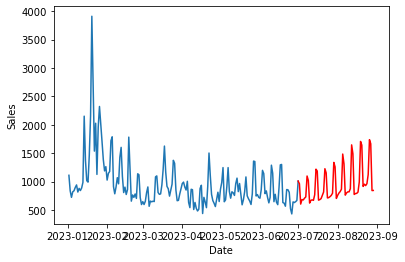

Ploting Category: 1011010201


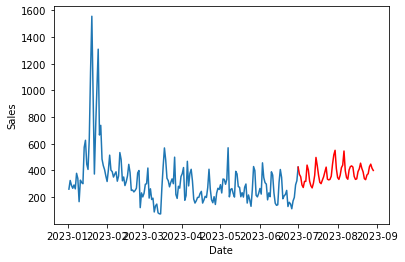

Ploting Category: 1011010402


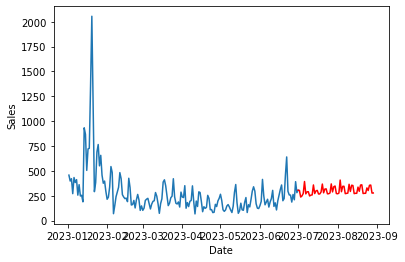

Ploting Category: 1011010501


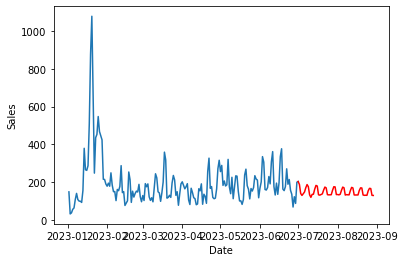

Ploting Category: 1011010504


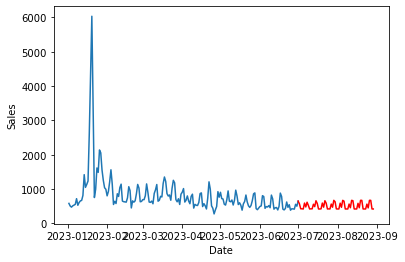

Ploting Category: 1011010801


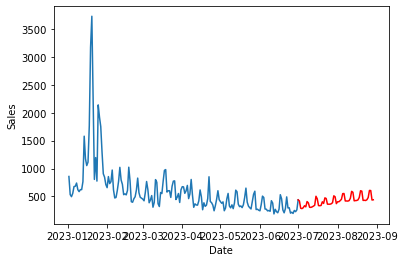

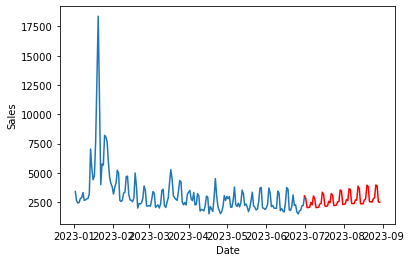

In [97]:
df_plot = df_all.copy()
df_plot['Date'] = pd.to_datetime(df_plot[['Year', 'Month', 'Day']])
for category in categories:
    latest_historical = df_agg[df_agg['Category Code'] == category]['Date'].max()
    latest_historical = dt.strptime(latest_historical, '%Y-%m-%d').date()
    
    print(f'Ploting Category: {category}')
    sns.lineplot(x = 'Date',
                 y = 'Sales',
                 data = df_plot[(df_plot['Category Code'] == category) & (df_plot['Date'].dt.date <= latest_historical + timedelta(days = 1)) & (df_plot['Date'].dt.date > latest_historical - timedelta(days = days_to_predict * 3))],)
    sns.lineplot(x = 'Date',
                 y = 'Sales',
                 data = df_plot[(df_plot['Category Code'] == category) & (df_plot['Date'].dt.date > latest_historical)],
                 color = 'red',
                 dashes = True)
    plt.show()

sns.lineplot(x = 'Date',
            y = 'Sales',
            data = df_plot[(df_plot['Date'].dt.date <= latest_historical + timedelta(days = 1)) & (df_plot['Date'].dt.date > latest_historical - timedelta(days = days_to_predict * 3))].groupby('Date', as_index = False)[['Sales']].sum())
sns.lineplot(x = 'Date',
            y = 'Sales',
            data = df_plot[(df_plot['Date'].dt.date > latest_historical)].groupby('Date', as_index = False)[['Sales']].sum(),
            color = 'red',
            dashes = True)
plt.show()

In [67]:
df_plot = df_all.copy()
df_plot['Date'] = pd.to_datetime(df_plot[['Year', 'Month', 'Day']])
df_plot['is_hitorical'] = df_plot.apply(lambda x: 1 if x['Date'].date() <= latest_historical and x['Category Code'] == category else 0, axis = 1)
df_plot.head()

,Sales,Year,Month,Day,DayOfWeek,WeekNumber,Quarter,lag_364,lag_7,lag_14,lag_28,Last New Year Sales,is_holiday,Category Code,Date,is_hitorical
0,1503.7896,2020,7,1,2,27,3,NaN,NaN,NaN,NaN,NaN,0,1011010101,2020-07-01,0
1,1409.6647,2020,7,2,3,27,3,NaN,NaN,NaN,NaN,NaN,0,1011010101,2020-07-02,0
2,1399.5065,2020,7,3,4,27,3,NaN,NaN,NaN,NaN,NaN,0,1011010101,2020-07-03,0
3,1841.4000,2020,7,4,5,27,3,NaN,NaN,NaN,NaN,NaN,0,1011010101,2020-07-04,0
4,1573.1793,2020,7,5,6,27,3,NaN,NaN,NaN,NaN,NaN,0,1011010101,2020-07-05,0


In [36]:
df_plot['Date'] = pd.to_datetime(df_plot[['Year', 'Month', 'Day']])

In [75]:
latest_historical = df_agg[df_agg['Category Code'] == category]['Date'].max()
latest_historical = dt.strptime(latest_historical, '%Y-%m-%d').date()
latest_historical

datetime.date(2023, 6, 30)

In [ ]:
latest_historical + timedelta(days = days_to_predict)

datetime.date(2023, 8, 29)